In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [2]:
base_dir = os.environ['PSCRATCH']
data_dir = "/data/test/mag_bin_0"
out_dir = base_dir + data_dir

files = np.sort(glob.glob(out_dir + "/*"))

mag_bins=[14,17]

## Mag Bin 0 ($m_{AB} = 14$)

In [3]:
def get_info(l):
    out = []
    for _ in l:
        if _.isdigit() or _.replace('.', '', 1).isdigit():
            out.append(_)
    return out

def get_2nd_moms(r):
    # Calculate Second Moments
    e1 = r.observed_shape.e1
    e2 = r.observed_shape.e2
    sigma = r.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


df = pd.DataFrame(columns=['mag_bin','nrecalc','bf_strength','psf_size', 'T_mu', 'T_mu_err'])

for i, file in enumerate(files):
    f = file[len(out_dir)+1:-4]
    info = get_info(f.split("_"))
    mag_bin = 0
    nrecalc = int(float(info[1]))
    bf_strength = float(info[2])
    psf_size = float(info[3])
    
    data = np.load(file,allow_pickle=True)
    Ts = []
    for datum in data:
        ixx, iyy, _ = get_2nd_moms(datum)
        Ts.append(ixx+iyy)

    T_mu = np.mean(Ts)
    T_mu_err = np.array(Ts)
    
    d = {'mag_bin' : int(mag_bin),
         'nrecalc' : nrecalc,
         'bf_strength': bf_strength,
         'psf_size': psf_size, 
         'T_mu': T_mu, 
         'T_mu_err': T_mu_err}

    df = df.append(d,ignore_index=True)


In [4]:
# Combine duplicate runs
cols = ['mag_bin','nrecalc','bf_strength','psf_size']
grouped_df = df.groupby(cols)

# Create a new DataFrame for each group
unique_dfs = []
for name, group in grouped_df:
    unique_df = group.copy()
    
    data = []
    for datum in unique_df['T_mu_err'].values:
        data.extend(list(datum))
    data=np.array(data)

    mu = np.mean(data)
    mu_err = np.std(data) / np.sqrt(len(data))
    
    unique_df = unique_df.iloc[0:1]

    unique_df['T_mu'] = mu
    unique_df['T_mu_err'] = mu_err

    unique_dfs.append(unique_df)

# Print the new DataFrames
df = pd.concat(unique_dfs)

print(df)

   mag_bin nrecalc  bf_strength  psf_size      T_mu  T_mu_err
0        0       1          1.0       0.4  1.796452  0.000204
2        0       1          2.0       0.4  1.964743  0.000392
3        0       1          5.0       0.4  2.415590  0.000208
1        0       1         10.0       0.4  3.052435  0.000306
4        0      10          1.0       0.4  1.796453  0.000203
6        0      10          2.0       0.4  1.964754  0.000393
7        0      10          5.0       0.4  2.415589  0.000209
5        0      10         10.0       0.4  3.052420  0.000306
8        0     100          1.0       0.4  1.796444  0.000203
10       0     100          2.0       0.4  1.964758  0.000392
11       0     100          5.0       0.4  2.415573  0.000209
9        0     100         10.0       0.4  3.052425  0.000305
12       0    1000          1.0       0.4  1.796383  0.000203
14       0    1000          2.0       0.4  1.964689  0.000392
15       0    1000          5.0       0.4  2.415549  0.000209
13      

In [5]:
df = df.sort_values(by=['bf_strength', 'nrecalc'], ascending=True)
print(df)

   mag_bin nrecalc  bf_strength  psf_size      T_mu  T_mu_err
0        0       1          1.0       0.4  1.796452  0.000204
4        0      10          1.0       0.4  1.796453  0.000203
8        0     100          1.0       0.4  1.796444  0.000203
12       0    1000          1.0       0.4  1.796383  0.000203
16       0   10000          1.0       0.4  1.795812  0.000205
2        0       1          2.0       0.4  1.964743  0.000392
6        0      10          2.0       0.4  1.964754  0.000393
10       0     100          2.0       0.4  1.964758  0.000392
14       0    1000          2.0       0.4  1.964689  0.000392
18       0   10000          2.0       0.4  1.964198  0.000393
3        0       1          5.0       0.4  2.415590  0.000208
7        0      10          5.0       0.4  2.415589  0.000209
11       0     100          5.0       0.4  2.415573  0.000209
15       0    1000          5.0       0.4  2.415549  0.000209
19       0   10000          5.0       0.4  2.415194  0.000209
1       

In [34]:
def plot_df(df, figsize=(3,7)):
    
    plt.figure(figsize=figsize)
    x = df['T_mu'].ravel()
    xerr = df['T_mu_err'].ravel()
    y = np.linspace(1,len(x), len(x))
    plt.errorbar(x, y, yerr=None, xerr=xerr, 
                     fmt="o",
                     markersize=3,
                     elinewidth=1, 
                     barsabove=False,
                     alpha=1, 
                     color='k')
    labels = []
    for i, d in df.iterrows():
        mag = mag_bins[int(d['mag_bin'])]
        nrecalc = d['nrecalc']
        bf_strength = d['bf_strength']
        label = "$m_{AB} = $" + str(mag) + ", $n = $" + str(int(nrecalc)) + ", bf $=$ " + str(bf_strength)
        labels.append(label)

    _=plt.yticks(y, labels=labels)

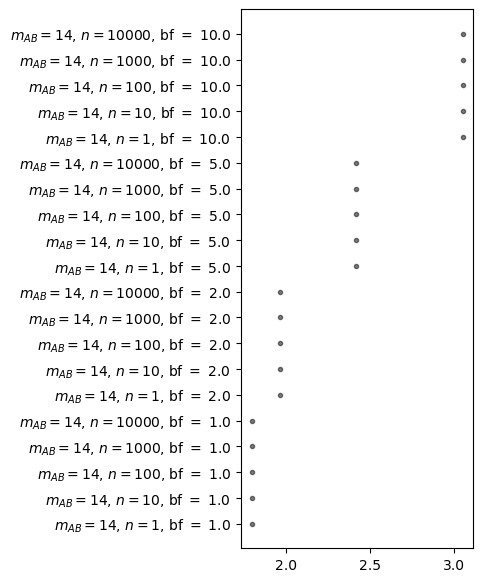

In [32]:
plot_df(df)

In [20]:
grouped_df = df.groupby(['bf_strength'])

# Create a new DataFrame for each group
sub_dfs = []
for name, group in grouped_df:
    sub_df = group.copy()
    sub_dfs.append(sub_df)

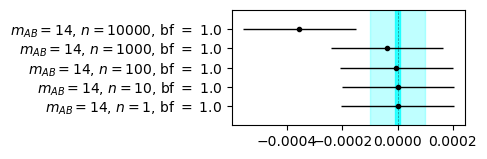

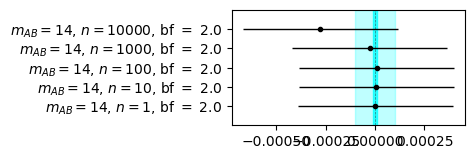

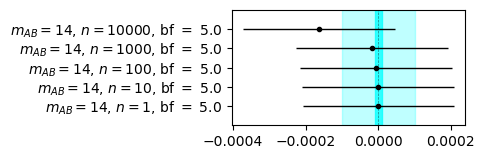

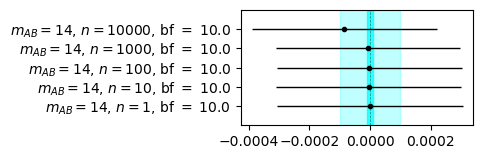

In [48]:
for sub_df in sub_dfs:
    plt.figure(figsize=(3,1.5))
    x = sub_df['T_mu'].ravel()
    xerr = sub_df['T_mu_err'].ravel()
    y = np.linspace(1,len(x), len(x))
    x = (x - x[0])/x[0]
    plt.errorbar(x, y, yerr=None, xerr=xerr, 
                     fmt="o",
                     markersize=3,
                     elinewidth=1, 
                     barsabove=False,
                     alpha=1, 
                     color='k')
    labels = []
    for i, d in sub_df.iterrows():
        mag = mag_bins[int(d['mag_bin'])]
        nrecalc = d['nrecalc']
        bf_strength = d['bf_strength']
        label = "$m_{AB} = $" + str(mag) + ", $n = $" + str(int(nrecalc)) + ", bf $=$ " + str(bf_strength)
        labels.append(label)
    plt.axvline(0, linestyle="--",color="k", linewidth=0.5,alpha=0.5)
    
    plt.fill_betweenx(np.linspace(0,len(x)+1, 2), x1=-1./10000., x2 = 1./10000., color='cyan', alpha=0.25)
    plt.fill_betweenx(np.linspace(0,len(x)+1, 2), x1=-1./100000., x2 = 1./100000., color='cyan', alpha=0.75)
    _=plt.yticks(y, labels=labels)
    plt.ylim((y[0]-1,y[-1]+1))

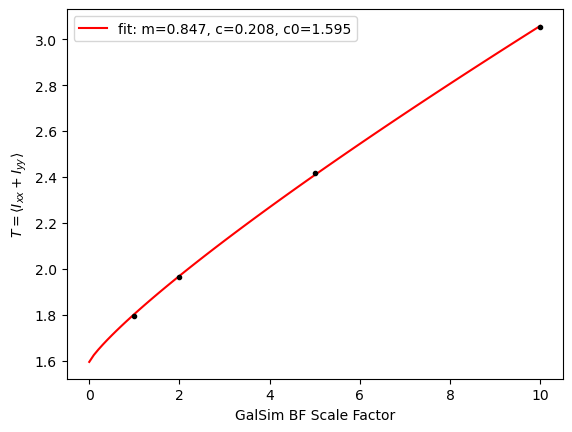

In [78]:
plt.figure()
Ts = []
T_errs = []
bfs = []
for sub_df in sub_dfs:
    sub_df = sub_df[sub_df['nrecalc'] == 1]
    Ts.append(np.mean(sub_df['T_mu']))
    T_errs.append(np.mean(sub_df['T_mu_err']))
    bfs.append(np.mean(sub_df['bf_strength']))

_ = plt.errorbar(bfs, Ts, yerr=T_errs, xerr=None, 
                 fmt="o",
                 markersize=3,
                 elinewidth=1, 
                 barsabove=False,
                 alpha=1, 
                 color='k')

from scipy.optimize import curve_fit

# Append zero signal
Ts.append(1.6136572483026457)
T_errs.append(0.00048013005682415383)
bfs.append(0,)


# Define the model
def model(x, m, c, c0):
    return c*(x**m) + c0

popt, pcov = curve_fit(model, bfs, Ts, p0=[0.5,0, 0], sigma=T_errs, absolute_sigma=True)
plt.plot(np.linspace(0,10, 100), model(np.linspace(0,10, 100), *popt), 'r-',
         label='fit: m=%5.3f, c=%5.3f, c0=%5.3f' % tuple(popt))

plt.xlabel("GalSim BF Scale Factor")
plt.ylabel(r"$T = \left \langle I_{xx} + I_{yy}\right \rangle$")
plt.legend()
